# Practical 2: GAN & Diffusion

## Task 1

In [2]:
!source lab2_env/bin/activate

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb

In [24]:
# Hyperparameters
mb_size = 64    # mini‑batch size, num of real/fake samples feedeng through the NN before doing one gradient update
Z_dim = 1000    # dimensionality of the latent noise vector 
h_dim = 128     # size of the hidden layers in both generator and discriminator
lr = 1e-3       # learning rate for the optimizer

In [25]:
# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

Xavier initialization balances signal flow through layers.
It fills each weight entry by drawing a random number from a Gaussian (normal) distribution,
whose mean is 0 and whose standard deviation is chosen according to the layer size.

In [26]:
# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [27]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

In [28]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg

In [29]:

def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


In [30]:
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)


In [31]:
#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


100%|██████████| 938/938 [00:13<00:00, 70.59it/s]


epoch0; D_loss: 0.0649; G_loss: 6.2063
Saved Best Models at epoch 0 | G_loss: 6.2063


100%|██████████| 938/938 [00:12<00:00, 75.93it/s]


epoch1; D_loss: 0.0264; G_loss: 7.0430


100%|██████████| 938/938 [00:12<00:00, 75.48it/s]


epoch2; D_loss: 0.0401; G_loss: 5.7147
Saved Best Models at epoch 2 | G_loss: 5.7147


100%|██████████| 938/938 [00:12<00:00, 74.67it/s]


epoch3; D_loss: 0.0777; G_loss: 6.1726


100%|██████████| 938/938 [00:12<00:00, 74.90it/s]


epoch4; D_loss: 0.1625; G_loss: 4.9435
Saved Best Models at epoch 4 | G_loss: 4.9435


100%|██████████| 938/938 [00:12<00:00, 75.46it/s]


epoch5; D_loss: 0.2758; G_loss: 4.0857
Saved Best Models at epoch 5 | G_loss: 4.0857


100%|██████████| 938/938 [00:12<00:00, 74.79it/s]


epoch6; D_loss: 0.3688; G_loss: 3.6070
Saved Best Models at epoch 6 | G_loss: 3.6070


100%|██████████| 938/938 [00:12<00:00, 74.63it/s]


epoch7; D_loss: 0.4320; G_loss: 3.2756
Saved Best Models at epoch 7 | G_loss: 3.2756


100%|██████████| 938/938 [00:12<00:00, 73.48it/s]


epoch8; D_loss: 0.4783; G_loss: 3.2761


100%|██████████| 938/938 [00:12<00:00, 73.91it/s]


epoch9; D_loss: 0.5457; G_loss: 2.9756
Saved Best Models at epoch 9 | G_loss: 2.9756


100%|██████████| 938/938 [00:12<00:00, 74.28it/s]


epoch10; D_loss: 0.5926; G_loss: 2.7817
Saved Best Models at epoch 10 | G_loss: 2.7817


100%|██████████| 938/938 [00:12<00:00, 74.85it/s]


epoch11; D_loss: 0.6427; G_loss: 2.6702
Saved Best Models at epoch 11 | G_loss: 2.6702


100%|██████████| 938/938 [00:12<00:00, 77.60it/s] 


epoch12; D_loss: 0.6549; G_loss: 2.5118
Saved Best Models at epoch 12 | G_loss: 2.5118


100%|██████████| 938/938 [00:12<00:00, 75.23it/s]


epoch13; D_loss: 0.6496; G_loss: 2.5436


100%|██████████| 938/938 [00:12<00:00, 74.65it/s]


epoch14; D_loss: 0.6400; G_loss: 2.5142


100%|██████████| 938/938 [00:12<00:00, 75.62it/s]


epoch15; D_loss: 0.6337; G_loss: 2.4481
Saved Best Models at epoch 15 | G_loss: 2.4481


100%|██████████| 938/938 [00:12<00:00, 74.92it/s]


epoch16; D_loss: 0.6426; G_loss: 2.4201
Saved Best Models at epoch 16 | G_loss: 2.4201


100%|██████████| 938/938 [00:12<00:00, 75.23it/s]


epoch17; D_loss: 0.6315; G_loss: 2.4210


100%|██████████| 938/938 [00:12<00:00, 74.07it/s]


epoch18; D_loss: 0.6306; G_loss: 2.4578


100%|██████████| 938/938 [00:12<00:00, 73.90it/s]


epoch19; D_loss: 0.6372; G_loss: 2.4028
Saved Best Models at epoch 19 | G_loss: 2.4028


100%|██████████| 938/938 [00:12<00:00, 75.08it/s]


epoch20; D_loss: 0.6391; G_loss: 2.4223


100%|██████████| 938/938 [00:12<00:00, 73.94it/s]


epoch21; D_loss: 0.6393; G_loss: 2.4234


100%|██████████| 938/938 [00:12<00:00, 75.39it/s]


epoch22; D_loss: 0.6419; G_loss: 2.3997
Saved Best Models at epoch 22 | G_loss: 2.3997


100%|██████████| 938/938 [00:12<00:00, 74.73it/s]


epoch23; D_loss: 0.6443; G_loss: 2.4342


100%|██████████| 938/938 [00:12<00:00, 74.82it/s]


epoch24; D_loss: 0.6459; G_loss: 2.4434


100%|██████████| 938/938 [00:12<00:00, 74.45it/s]


epoch25; D_loss: 0.6474; G_loss: 2.4323


100%|██████████| 938/938 [00:12<00:00, 75.12it/s]


epoch26; D_loss: 0.6382; G_loss: 2.4511


100%|██████████| 938/938 [00:12<00:00, 74.68it/s]


epoch27; D_loss: 0.6258; G_loss: 2.5040


100%|██████████| 938/938 [00:12<00:00, 74.46it/s]


epoch28; D_loss: 0.6297; G_loss: 2.5083


100%|██████████| 938/938 [00:12<00:00, 76.05it/s]


epoch29; D_loss: 0.6268; G_loss: 2.5041


100%|██████████| 938/938 [00:12<00:00, 75.21it/s]


epoch30; D_loss: 0.6220; G_loss: 2.5646


100%|██████████| 938/938 [00:11<00:00, 79.93it/s] 


epoch31; D_loss: 0.6165; G_loss: 2.5571


100%|██████████| 938/938 [00:12<00:00, 73.90it/s]


epoch32; D_loss: 0.6129; G_loss: 2.5886


100%|██████████| 938/938 [00:12<00:00, 74.47it/s]


epoch33; D_loss: 0.6065; G_loss: 2.5820


100%|██████████| 938/938 [00:12<00:00, 74.33it/s]


epoch34; D_loss: 0.6030; G_loss: 2.6472


100%|██████████| 938/938 [00:12<00:00, 74.70it/s]


epoch35; D_loss: 0.5984; G_loss: 2.6427


100%|██████████| 938/938 [00:12<00:00, 74.50it/s]


epoch36; D_loss: 0.5878; G_loss: 2.6582


100%|██████████| 938/938 [00:12<00:00, 74.24it/s]


epoch37; D_loss: 0.5877; G_loss: 2.6772


100%|██████████| 938/938 [00:12<00:00, 74.44it/s]


epoch38; D_loss: 0.5781; G_loss: 2.6913


100%|██████████| 938/938 [00:12<00:00, 75.30it/s]


epoch39; D_loss: 0.5737; G_loss: 2.7450


100%|██████████| 938/938 [00:12<00:00, 74.57it/s]


epoch40; D_loss: 0.5701; G_loss: 2.7428


100%|██████████| 938/938 [00:12<00:00, 75.17it/s]


epoch41; D_loss: 0.5659; G_loss: 2.7770


100%|██████████| 938/938 [00:11<00:00, 85.03it/s] 


epoch42; D_loss: 0.5576; G_loss: 2.7932


100%|██████████| 938/938 [00:12<00:00, 73.26it/s]


epoch43; D_loss: 0.5532; G_loss: 2.7973


100%|██████████| 938/938 [00:12<00:00, 77.79it/s] 


epoch44; D_loss: 0.5494; G_loss: 2.8130


100%|██████████| 938/938 [00:12<00:00, 74.25it/s]


epoch45; D_loss: 0.5475; G_loss: 2.8354


100%|██████████| 938/938 [00:12<00:00, 73.79it/s]


epoch46; D_loss: 0.5449; G_loss: 2.8337


100%|██████████| 938/938 [00:12<00:00, 75.03it/s]


epoch47; D_loss: 0.5400; G_loss: 2.8213


100%|██████████| 938/938 [00:12<00:00, 75.14it/s]


epoch48; D_loss: 0.5375; G_loss: 2.8373


100%|██████████| 938/938 [00:12<00:00, 76.10it/s]


epoch49; D_loss: 0.5326; G_loss: 2.8182


100%|██████████| 938/938 [00:12<00:00, 75.58it/s]


epoch50; D_loss: 0.5335; G_loss: 2.8310


100%|██████████| 938/938 [00:12<00:00, 74.45it/s]


epoch51; D_loss: 0.5280; G_loss: 2.8338


100%|██████████| 938/938 [00:11<00:00, 82.44it/s] 


epoch52; D_loss: 0.5232; G_loss: 2.8588


100%|██████████| 938/938 [00:09<00:00, 98.05it/s] 


epoch53; D_loss: 0.5226; G_loss: 2.8479


100%|██████████| 938/938 [00:12<00:00, 74.80it/s]


epoch54; D_loss: 0.5229; G_loss: 2.8431


100%|██████████| 938/938 [00:09<00:00, 104.16it/s]


epoch55; D_loss: 0.5179; G_loss: 2.8594


100%|██████████| 938/938 [00:11<00:00, 78.64it/s] 


epoch56; D_loss: 0.5112; G_loss: 2.8584


100%|██████████| 938/938 [00:12<00:00, 75.88it/s]


epoch57; D_loss: 0.5127; G_loss: 2.8867


100%|██████████| 938/938 [00:12<00:00, 75.02it/s]


epoch58; D_loss: 0.5009; G_loss: 2.9081


100%|██████████| 938/938 [00:12<00:00, 73.77it/s]


epoch59; D_loss: 0.5036; G_loss: 2.9051


100%|██████████| 938/938 [00:12<00:00, 74.83it/s]


epoch60; D_loss: 0.5035; G_loss: 2.8809


100%|██████████| 938/938 [00:12<00:00, 73.98it/s]


epoch61; D_loss: 0.4979; G_loss: 2.8595


100%|██████████| 938/938 [00:12<00:00, 75.14it/s]


epoch62; D_loss: 0.4936; G_loss: 2.8964


100%|██████████| 938/938 [00:12<00:00, 74.27it/s]


epoch63; D_loss: 0.4858; G_loss: 2.9249


100%|██████████| 938/938 [00:12<00:00, 77.01it/s] 


epoch64; D_loss: 0.4842; G_loss: 2.9071


100%|██████████| 938/938 [00:12<00:00, 74.35it/s]


epoch65; D_loss: 0.4775; G_loss: 2.9287


100%|██████████| 938/938 [00:12<00:00, 73.23it/s]


epoch66; D_loss: 0.4770; G_loss: 2.9503


100%|██████████| 938/938 [00:11<00:00, 80.25it/s] 


epoch67; D_loss: 0.4707; G_loss: 2.9447


100%|██████████| 938/938 [00:12<00:00, 75.72it/s]


epoch68; D_loss: 0.4669; G_loss: 2.9491


100%|██████████| 938/938 [00:12<00:00, 74.69it/s]


epoch69; D_loss: 0.4618; G_loss: 2.9710


100%|██████████| 938/938 [00:12<00:00, 76.21it/s]


epoch70; D_loss: 0.4584; G_loss: 2.9852


100%|██████████| 938/938 [00:12<00:00, 74.54it/s]


epoch71; D_loss: 0.4509; G_loss: 3.0086


100%|██████████| 938/938 [00:12<00:00, 74.30it/s]


epoch72; D_loss: 0.4475; G_loss: 3.0001


100%|██████████| 938/938 [00:12<00:00, 74.38it/s]


epoch73; D_loss: 0.4424; G_loss: 3.0302


100%|██████████| 938/938 [00:12<00:00, 74.69it/s]


epoch74; D_loss: 0.4398; G_loss: 3.0558


100%|██████████| 938/938 [00:12<00:00, 74.58it/s]


epoch75; D_loss: 0.4381; G_loss: 3.0808


100%|██████████| 938/938 [00:12<00:00, 74.29it/s]


epoch76; D_loss: 0.4338; G_loss: 3.0659


100%|██████████| 938/938 [00:12<00:00, 73.51it/s]


epoch77; D_loss: 0.4320; G_loss: 3.0990


100%|██████████| 938/938 [00:12<00:00, 73.61it/s]


epoch78; D_loss: 0.4294; G_loss: 3.1252


100%|██████████| 938/938 [00:12<00:00, 74.66it/s]


epoch79; D_loss: 0.4240; G_loss: 3.1194


100%|██████████| 938/938 [00:12<00:00, 74.69it/s]


epoch80; D_loss: 0.4229; G_loss: 3.1396


100%|██████████| 938/938 [00:12<00:00, 74.28it/s]


epoch81; D_loss: 0.4192; G_loss: 3.1591


100%|██████████| 938/938 [00:12<00:00, 74.43it/s]


epoch82; D_loss: 0.4190; G_loss: 3.1373


100%|██████████| 938/938 [00:10<00:00, 88.52it/s] 


epoch83; D_loss: 0.4130; G_loss: 3.1736


100%|██████████| 938/938 [00:12<00:00, 74.64it/s]


epoch84; D_loss: 0.4193; G_loss: 3.2039


100%|██████████| 938/938 [00:12<00:00, 74.04it/s]


epoch85; D_loss: 0.4115; G_loss: 3.2076


100%|██████████| 938/938 [00:11<00:00, 83.72it/s] 


epoch86; D_loss: 0.4109; G_loss: 3.2455


100%|██████████| 938/938 [00:12<00:00, 74.24it/s]


epoch87; D_loss: 0.4058; G_loss: 3.2323


100%|██████████| 938/938 [00:12<00:00, 75.02it/s]


epoch88; D_loss: 0.4014; G_loss: 3.2678


100%|██████████| 938/938 [00:12<00:00, 74.12it/s]


epoch89; D_loss: 0.3993; G_loss: 3.3012


100%|██████████| 938/938 [00:12<00:00, 74.30it/s]


epoch90; D_loss: 0.3929; G_loss: 3.3080


100%|██████████| 938/938 [00:12<00:00, 74.43it/s]


epoch91; D_loss: 0.3977; G_loss: 3.3436


100%|██████████| 938/938 [00:09<00:00, 103.18it/s]


epoch92; D_loss: 0.3957; G_loss: 3.3058


100%|██████████| 938/938 [00:12<00:00, 73.82it/s]


epoch93; D_loss: 0.3933; G_loss: 3.3694


100%|██████████| 938/938 [00:12<00:00, 74.50it/s]


epoch94; D_loss: 0.3943; G_loss: 3.3707


100%|██████████| 938/938 [00:12<00:00, 74.62it/s]


epoch95; D_loss: 0.3902; G_loss: 3.3734


100%|██████████| 938/938 [00:12<00:00, 73.75it/s]


epoch96; D_loss: 0.3906; G_loss: 3.4059


100%|██████████| 938/938 [00:12<00:00, 74.52it/s]


epoch97; D_loss: 0.3880; G_loss: 3.4076


100%|██████████| 938/938 [00:12<00:00, 74.01it/s]


epoch98; D_loss: 0.3843; G_loss: 3.3968


100%|██████████| 938/938 [00:12<00:00, 75.24it/s]


epoch99; D_loss: 0.3864; G_loss: 3.4412


In [33]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

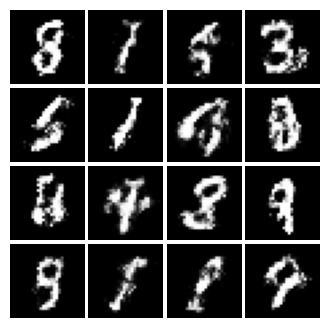

In [17]:
from IPython.display import Image, display
display(Image("best.png"))

## Task 2